In [11]:
#-------------------------Imports---------------------------
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy.random import random

from scipy.stats import uniform
from scipy import interpolate
from scipy.integrate import quad
from scipy import constants

import os
#from astropy.cosmology import Planck15
from astropy.cosmology import Planck18
from astropy.cosmology import FlatLambdaCDM

from multiprocessing import Pool
import time

###########################
# CONSTANTS
###########################
H0GLOB= 69.32#67.9 #69
Om0GLOB=0.298
Xi0Glob =1.
clight = 2.99792458* 10**5#km/s
cosmoglob = Planck18
cosmofast = FlatLambdaCDM(H0=H0GLOB, Om0=Om0GLOB)
H0=cosmoglob.H(0).value
h=H0/100
#geometrization of masses
Msun=(1.98892)*(10**30)
solarmass_to_m=(constants.G*Msun)/((constants.c)**2)#G/c^2
Mpc_to_m=3.08567758128*(10**22) #this will be used later

In [12]:
#--------Functions--------------------------------
#The integral can be performed with [dl]=s and [M_c]=s or [dl]=m and [M_c]=m and [f]=m
def hplus_new(f,constant,mass,dist,z,cos):
    dist=dist*Mpc_to_m
    dist=dist/constants.c
    mass=mass/constants.c
    #x=f/constants.c
    numerator=((constant/dist)*(mass**(5/6))*(((1+cos**2)/2)**2)*f**(-7/6))**2
    #denom=Aligo_sn(f)
    #denom=(constants.c**2)*(Aligo_sn(f)**2)#We need the noise power spectra
    #denom=(Aligo_sn(f)**2)
    denom=(ET_sn(f)**2)
    return (numerator/denom) 

def hcross_new(f,constant,mass,dist,z,cos):
    dist=dist*Mpc_to_m
    dist=dist/constants.c
    mass=mass/constants.c
    #x=f/constants.c
    numerator=((constant/dist)*(mass**(5/6))*(cos**2)*f**(-7/6))**2
    #denom=Aligo_sn(f)
    #denom=(constants.c**2)*(Aligo_sn(f)**2) #We need the noise power spectra
    #denom=(Aligo_sn(f)**2)
    denom=(ET_sn(f)**2)
    return (numerator/denom)
#-----------------Einstein Telescope Stuff------------------------------
#we will make two antenna functions, one is theresponse of a single interferometer
#the other will be the same as before, after a mean on psi

def ET_antenna_one_plus(cos_theta,phi,psi):
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.sin(2*phi))
    B=2*(cos_theta)*(np.cos(2*phi))
    ret=-prefactor*(A*np.cos(2*psi)+B*np.sin(2*psi))
    return ret
def ET_antenna_one_cross(cos_theta,phi,psi):
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.sin(2*phi))
    B=2*(cos_theta)*(np.cos(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
def ET_antenna_two_plus(cos_theta,phi,psi):
    phi=phi+(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.sin(2*phi))
    B=2*(cos_theta)*(np.cos(2*phi))
    ret=-prefactor*(A*np.cos(2*psi)+B*np.sin(2*psi))
    return ret
def ET_antenna_two_cross(cos_theta,phi,psi):
    phi=phi+(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.sin(2*phi))
    B=2*(cos_theta)*(np.cos(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
def ET_antenna_three_plus(cos_theta,phi,psi):
    phi=phi-(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.sin(2*phi))
    B=2*(cos_theta)*(np.cos(2*phi))
    ret=-prefactor*(A*np.cos(2*psi)+B*np.sin(2*psi))
    return ret
def ET_antenna_three_cross(cos_theta,phi,psi):
    phi=phi-(2*np.pi/3)
    prefactor=np.sqrt(3)/4
    A=(1+cos_theta**2)*(np.sin(2*phi))
    B=2*(cos_theta)*(np.cos(2*phi))
    ret=prefactor*(A*np.sin(2*psi)+B*np.cos(2*psi))
    return ret
#constant is a prefactor for the signal, mass must be the redshifted mass, angles are vectors
def ET_SNR_quad(f,constant,mass,dist,cos_i,ds_cos_theta,ds_phi,ds_psi):
    dist=dist*Mpc_to_m
    cos_theta=np.random.choice(ds_cos_theta)
    phi=np.random.choice(ds_phi)
    psi=np.random.choice(ds_psi)
    hplus_squared=((constant/dist)*(mass**(5/6))*(((1+cos_i**2)/2)**2)*f**(-7/6))**2
    hcross_squared=((constant/dist)*(mass**(5/6))*(cos_i**2)*f**(-7/6))**2
    numerator01=hplus_squared*(ET_antenna_one_plus(cos_theta,phi,psi))**2 + hcross_squared*(ET_antenna_one_cross(cos_theta,phi,psi))**2
    denom=ET_sn(f)**2
    first=4*numerator01/denom
    numerator02=hplus_squared*(ET_antenna_two_plus(cos_theta,phi,psi))**2 + hcross_squared*(ET_antenna_two_cross(cos_theta,phi,psi))**2
    second=4*numerator02/denom
    numerator03=hplus_squared*(ET_antenna_three_plus(cos_theta,phi,psi))**2 + hcross_squared*(ET_antenna_three_cross(cos_theta,phi,psi))**2
    third=4*numerator03/denom
    ret=np.array([first,second,third])
    return ret
zz=np.linspace(0,20,10000)
distinterpol=cosmoglob.comoving_distance(zz).value*(1+zz)
z_of_dl=interpolate.interp1d(distinterpol,zz)

In [ ]:
#network antenna from: Networks of gravitational wave detectors and three figures of merit
#we have to set a global reference frame and evaluate f_+ and f_x for each detector
#having care to rotate each S.o.R.
def A_factor(xi,beta,lamb,theta,phi):
    a1=(1/16)*np.cos(2*xi)*(3-np.cos(2*beta))*(3-np.cos(2*theta))*np.cos(2*(phi+lamb))
    a2=0.25*np.cos(2*xi)*np.sin(beta)*(3-np.cos(2*theta))*np.sin(2*(phi+lamb))
    a3=0.25*np.sin(2*xi)*np.sin(2*beta)*np.sin(2*theta)*np.cos(phi+lamb)
    a4=0.5*np.cos(2*xi)*np.cos(beta)*np.sin(2*theta)*np.sin(phi+lamb)
    a5=(3/4)*np.sin(2*xi)*(np.cos(beta)**2)*(np.sin(theta)**2)
    ret=a1+a2+a3+a4+a5
    return ret
def B_factor(xi,beta,lamb,theta,phi):
    b1=np.cos(2*xi)*np.sin(beta)*np.cos(theta)*np.cos(2*(phi+lamb))
    b2=0.25*np.sin(2*xi)*(3-np.cos(2*beta))*np.cos(theta)*np.sin(2*(phi+lamb))
    b3=np.cos(2*xi)*np.cos(beta)*np.sin(theta)*np.cos(phi+lamb)
    b4=0.5*np.sin(2*xi)*np.sin(2*beta)*np.sin(theta)*np.sin(phi+lamb)
    ret=b1-b2+b3-b4
    return ret
def antenna_pattern(xi,beta,lamb,theta,phi,psi):
    fplus=A_factor(xi,beta,lamb,theta,phi)*np.cos(2*psi)+B_factor(xi,beta,lamb,theta,phi)*np.sin(2*psi)
    fcross=B_factor(xi,beta,lamb,theta,phi)*np.cos(2*psi)-A_factor(xi,beta,lamb,theta,phi)*np.sin(2*psi)
    fplus_squared=fplus**2
    fcross_squared=fcross**2
    ret=fplus_squared+fcross_squared
    return ret
def rad_from_deg(angle):
    if angle<0:
        convert=360+angle #angle is negative
    else:
        convert=angle
    ret=convert*np.pi/180
    return ret
#gamma, lambda, L of other paper
Ligo_H=np.array([rad_from_deg(171.8),rad_from_deg(46.45),rad_from_deg(119.41)])
Ligo_L=np.array([rad_from_deg(243),rad_from_deg(30.56),rad_from_deg(90.77)])
Virgo=np.array([rad_from_deg(116.5),rad_from_deg(43.63),rad_from_deg(-10.5)])


In [ ]:
def weights(dist_ds):
    n_iteration=len(dist_ds)
    detected=np.zeros(n_iteration)
    for k in tqdm(range(n_iteration),desc='Progress'):
        for i in range(n_BBH):
            dl=np.random.uniform(dist_ds[k],dist_ds[k]+10)
            z_ds=z_of_dl(dl)
            red_Mc=M_c*(1+z_ds)
            cos_i=np.random.choice(cos_inclination)
            temp_plus=quad(hplus_new,20,1000,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
            temp_cross=quad(hcross_new,20,1000,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
            SNR=2*np.sqrt((temp_plus+temp_cross)*mean_angular_power)
            #integral=quad(full_integrand,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,cos_i,arr_cos,arr_phi,arr_psi))[0]
            #SNR=np.sqrt((integral)*4)
            if SNR >= 8:
                detected[k]=detected[k]+1
    return detected
def weights_multi(dist_ds):
    det=0
    for i in range(n_BBH):
        dl=np.random.uniform(dist_ds,dist_ds+10)
        z_ds=z_of_dl(dl)
        red_Mc=M_c*(1+z_ds)
        cos_i=np.random.choice(cos_inclination)
        temp_plus=quad(hplus_new,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
        temp_cross=quad(hcross_new,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
        detector_prefactor=antenna_response(all_cos,all_phi,arr_psi)
        SNR=np.sqrt((temp_plus+temp_cross)*detector_prefactor*4)
        #integral=quad(full_integrand,freq.min(),freq.max(),args=(prefactor,red_Mc,dl,cos_i,arr_cos,arr_phi,arr_psi))[0]
        #SNR=np.sqrt((integral)*4)
        if SNR >= 8:
            det=det+1
    return det


In [13]:
#---------ET weights----------------------------------
def ET_response(dist_ds):
    det=0
    for i in range(n_BBH):
        dl=dist_ds#np.random.uniform(dist_ds,dist_ds+1)
        z_ds=z_of_dl(dl)
        red_Mc=M_c*(1+z_ds)
        cos_i=np.random.choice(cos_inclination)
        temp_plus=quad(hplus_new,ET_min_freq,ET_max_freq,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
        temp_cross=quad(hcross_new,ET_min_freq,ET_max_freq,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
        ds_phi=np.random.choice(arr_phi)
        ds_theta=np.arccos(np.random.choice(arr_cos))
        ds_psi=np.random.choice(arr_psi)
        first_prefactor=(ET_antenna_one_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_one_cross(ds_theta,ds_phi,ds_psi))**2
        firstSNR=(temp_plus+temp_cross)*first_prefactor*4
        second_prefactor=(ET_antenna_two_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_two_cross(ds_theta,ds_phi,ds_psi))**2
        secondSNR=(temp_plus+temp_cross)*second_prefactor*4
        third_prefactor=(ET_antenna_three_plus(ds_theta,ds_phi,ds_psi))**2+(ET_antenna_three_cross(ds_theta,ds_phi,ds_psi))**2
        thirdSNR=(temp_plus+temp_cross)*third_prefactor*4
        totSNR=np.sqrt(firstSNR+secondSNR+thirdSNR)
        if totSNR>=20:
            det=det+1
    return det

In [14]:
#---------------Einstein Telescope Noise-----------------
ET_freq=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=0)
ET_noise=np.loadtxt('ET-0000A-18_ETDSensitivityCurveTxtFile.txt',usecols=3)#This is the amplitude so must be squared
ET_sn=interpolate.interp1d(ET_freq,ET_noise)
ET_min_freq=ET_freq.min()
ET_max_freq=ET_freq.max()

In [ ]:
#------------------------A_LIGO-noise------------------------
#data from https://dcc.ligo.org/LIGO-T1800044/public
freq=np.loadtxt('ALIGO_sens.txt',usecols=0)
noise=np.loadtxt('ALIGO_sens.txt',usecols=1)#This is the amplitude so must be squared
Aligo_sn=interpolate.interp1d(freq,noise)
#max_noise=noise.max()
#norm_noise=noise/max_noise
#Aligo_sn_norm=interpolate.interp1d(freq,norm_noise)

In [15]:
m1=10#Solar Mass units
m2=10
m1=m1*solarmass_to_m
m2=m2*solarmass_to_m

M=m1+m2
eta=(m1*m2)/(M**2)
M_c=M*eta**(3/5)#This mass must be redshifted
prefactor=np.sqrt((5/24))*((np.pi)**(-2/3))
cos_inclination=np.linspace(-1,1,100)
dist_min=50#lum dist
dist_max=20050#lum dist
n_bins=int((dist_max-dist_min)/200)
distances=np.linspace(dist_min,dist_max,n_bins)
n_BBH=150
arr_phi=np.random.uniform(0,2*np.pi,500000)
arr_cos=np.random.uniform(1,-1,500000)
arr_psi=np.random.uniform(0,2*np.pi,500000)
print('Chirp mass={}, Total Mass={} Max Redshift={}'.format(M_c/solarmass_to_m,M/solarmass_to_m,z_of_dl(dist_max)))

Chirp mass=8.705505632961241, Total Mass=20.0 Max Redshift=2.417170012697321


In [16]:
start_time = time.time()
with Pool(35) as p:
    etdetected=p.map(ET_response, distances)
print("--- %s seconds ---" % (time.time() - start_time))

<ipython-input-13-14984d6e4e53>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(hplus_new,ET_min_freq,ET_max_freq,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
<ipython-input-13-14984d6e4e53>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrato

<ipython-input-13-14984d6e4e53>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(hplus_new,ET_min_freq,ET_max_freq,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
<ipython-input-13-14984d6e4e53>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrato

<ipython-input-13-14984d6e4e53>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_plus=quad(hplus_new,ET_min_freq,ET_max_freq,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
<ipython-input-13-14984d6e4e53>:9: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrato

<ipython-input-13-14984d6e4e53>:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_cross=quad(hcross_new,ET_min_freq,ET_max_freq,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
<ipython-input-13-14984d6e4e53>:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integ

<ipython-input-13-14984d6e4e53>:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  temp_cross=quad(hcross_new,ET_min_freq,ET_max_freq,args=(prefactor,red_Mc,dl,z_ds,cos_i))[0]
<ipython-input-13-14984d6e4e53>:10: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integ

--- 60.01618695259094 seconds ---


Text(0, 0.5, '% Detected')

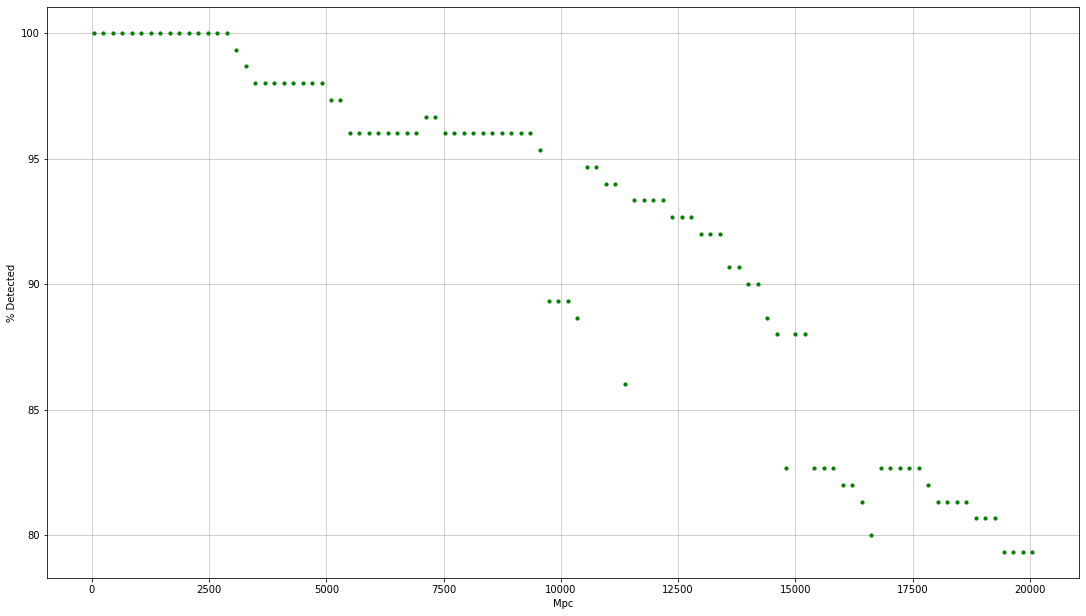

In [18]:
arr1=np.array(etdetected)
arr1=100*arr1/n_BBH
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.scatter(distances,arr1 , s=10, c='g', zorder=10)
#ax.fill_between(xx,1,-1,alpha=0.55, color='palegreen')

plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.xlabel('Mpc')
plt.ylabel('% Detected')
#plt.xscale('log')

In [19]:
#######--Some Miscellaneous plots--##########
freq_for_plot_ET=np.linspace(ET_freq.min(),ET_freq.max(),100000)
#freq_for_plot_ligo=np.linspace(freq.min(),freq.max(),100000)
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('Frequency')
ax.set_ylabel('S_n (1/Hz)')
ax.plot(freq_for_plot_ligo,Aligo_sn(freq_for_plot_ligo)**2,label='A-LIGO PSD')
ax.plot(freq_for_plot_ET,ET_sn(freq_for_plot_ET)**2,label='ET PSD')
plt.yscale('log')
plt.xscale('log')
plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.legend()

NameError: name 'freq' is not defined

In [ ]:
cosmoglob.comoving_distance(10).value-10000

In [ ]:
arr=np.array(detected_multi)
hanford=np.array(hanford)
livingstone=np.array(livingstone)
virgo=np.array(virgo)

arr=100*arr/n_BBH
hanford=100*hanford/n_BBH
livingstone=100*livingstone/n_BBH
virgo=100*virgo/n_BBH

fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.scatter(distances,arr , s=10, c='g', zorder=10)
#ax.fill_between(xx,1,-1,alpha=0.55, color='palegreen')

plt.grid(axis='y', alpha=0.75)
plt.xlabel('Mpc')
plt.ylabel('% Detected')
#plt.xscale('log')

In [ ]:
fig,ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
ax.set_xlabel('x')
ax.scatter(distances,arr , s=10, c='g', zorder=10,label='total')
#ax.scatter(distances,arr1 , s=10, c='b', zorder=10)
ax.scatter(distances,hanford , s=10, c='k', zorder=10,label='Hanford')
ax.scatter(distances,livingstone , s=10, c='r', zorder=10,label='Livingstone')
ax.scatter(distances,virgo , s=10, c='m', zorder=10,label='Virgo')
#ax.fill_between(distances,arr,arr1,alpha=0.55, color='palegreen')

plt.grid(axis='y', alpha=0.75)
plt.grid(axis='x', alpha=0.75)
plt.xlabel('Mpc')
plt.ylabel('% Detected')
plt.legend()
plt.xscale('log')
#plt.savefig('MC_Weights_AllSky.pdf')